# Baseline Modelling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from scipy.sparse import issparse
from sklearn.manifold import TSNE

In [2]:
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/Application_Ranking_System


## Reading the data

In [3]:
df = pd.read_csv(f"{path}/data/synthetic_data/synthetic_data_v1.csv")
df

,job_data,resume_data,label
0,Master Scheduler\nBaltimore Aircoil Company (B...,# *John Miller*\n\n**Professional Summary**\n\...,Complete Mismatch
1,Master Scheduler\nBaltimore Aircoil Company (B...,# James Casey\n\n## Professional Summary\n\nHi...,Underwhelming
2,Master Scheduler\nBaltimore Aircoil Company (B...,# Rachel Vargas\n\n## Professional Summary\n\n...,Good Fit
3,Master Scheduler\nBaltimore Aircoil Company (B...,# Susan Bradley\n\n**Professional Summary**\n\...,Overqualified
4,Master Technician\nCompany / Location Informat...,# Sean Johnson\n\n## Professional Summary\n\nD...,Complete Mismatch
...,...,...,...
5995,Account Executive Digital Sales\nOverview\nSal...,# Todd Walters\n\n**Professional Summary**\n\n...,Overqualified
5996,"Account Executive, Industrial Equipment\nWith ...",**DOUGLAS BLAKE**\n\n**Professional Summary**\...,Complete Mismatch
5997,"Account Executive, Industrial Equipment\nWith ...",# Kyle Villegas\n\n## Professional Summary\n\n...,Underwhelming
5998,"Account Executive, Industrial Equipment\nWith ...",# Charles Preston\n\n**Professional Summary**\...,Good Fit


In [4]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])

Number of rows in the dataset: 6000
Number of columns in the dataset: 3


In [5]:
df['label'].value_counts()

label
Complete Mismatch    1518
Underwhelming        1499
Good Fit             1498
Overqualified        1485
Name: count, dtype: int64

## Data preprocessing

In [6]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("overqualified")
stop_words.add("underqualified")
stop_words.add("mismatch")
stop_words.add("good")
print(stop_words)

{'couldn', 'weren', 'has', 'needn', 'same', 'are', 'an', "i'm", 'overqualified', 'had', 'in', "it's", 'out', 'some', "they've", 'you', 'only', 'at', 'for', 'theirs', 'him', 'were', "they're", 'off', "i've", 'himself', 'there', 'up', "weren't", 'through', 's', 'ain', 'mustn', 'but', "hadn't", 'nor', 'our', 'should', 'does', "he'd", 'have', 'too', 'or', "he'll", 'them', 'just', 'will', 'he', "he's", 'its', 'do', "shouldn't", "that'll", 'having', 'which', 'we', 'o', 'more', 'good', 'they', 'am', 'don', "wasn't", 'y', 'than', 'his', "doesn't", "won't", 'yourself', "hasn't", 'once', 'themselves', 'into', 'no', 'those', 'was', 'underqualified', 'yours', 'doesn', 'while', "couldn't", 'each', "needn't", 'their', 'from', 'haven', 'can', "you'd", 'and', 'ma', "you're", "you've", 'if', 'mightn', 'd', 'when', 'the', "didn't", 'it', "it'll", "haven't", 'all', 't', 'to', 'herself', 'very', 'under', 'whom', 'then', 'how', 'further', 'a', "i'll", "she's", 'of', 'this', 'over', 'll', "you'll", "she'll"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove unwanted symbols except %, $, /, and .
    text = re.sub(r"[^a-z0-9\s%$/.-]", "", text)

    # Preserve hyphens only when followed by a number (e.g., 2005-2010, 2010-present)
    text = re.sub(r"-(?!\d)", "", text)  # Remove hyphens not followed by a digit

    # Preserve GPA-like formats (e.g., 3.8/4.0)
    text = re.sub(r"(?<!\d)/|/(?!\d)", " ", text)  # Remove '/' unless between numbers

    # Remove periods (".") if they are immediately after a word but not numbers (e.g., "good." → "good", but keep 3.8)
    text = re.sub(r"\b(\w+)\.(?!\d)", r"\1", text)

    # Remove newline characters
    text = text.replace("\n", " ").replace("\r", " ")

    # Remove any show less and show more texts
    text = text.replace("show less", "").replace("show more", "")
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)

    return text

In [8]:
df['job_data_preprocessed'] = df['job_data'].apply(preprocess_text)
df['resume_data_preprocessed'] = df['resume_data'].apply(preprocess_text)

In [9]:
print(df.iloc[100]['job_data'])
print("\n******************************************************\n")
print(df.iloc[100]['job_data_preprocessed'])

Mortgage Advisor
At Pinnacle, our goal is to create an atmosphere where people become fully engaged, enjoy what they're doing and be successful. We work to ensure that every associate embraces what makes Pinnacle different and unique. For us, it starts with hiring the right people.
We hire like-minded individuals who share our values of Integrity, Fairness, Learning, Results, Partnership, Balance, and Discipline.
We hire experienced professionals who understand the industry and provide effective advice.
We hire candidates who demonstrate a passion for client service. People who understand that distinctive service is more than smiling and being friendly – it’s about creating a client experience that is unmatched.
But attracting the right people is only half the battle. We have to ensure that every associate understands their actions affects the outcomes of the firm. Our Position Descriptions are not designed to list every aspect of a position but to serve as a general overview.
Summary 

In [10]:
print(df.iloc[100]['resume_data'])
print("\n******************************************************\n")
print(df.iloc[100]['resume_data_preprocessed'])

# *Heather Neal*

**Professional Summary**

Dedicated and experienced *Veterinarian* with a strong background in animal care and welfare. Proven ability to manage high-volume caseloads, provide compassionate care, and maintain positive relationships with clients. Seeking to leverage expertise in a new and challenging role.

**Skills**

- Animal handling and restraint
- Surgical procedures
- Diagnostic testing and interpretation
- Client communication and education
- Electronic medical records management
- Team leadership and development
- Public speaking and presentations
- Microsoft Office (Word, Excel, PowerPoint)
- Veterinary software (AVImark, ImproMed)
- Animal nutrition and behavior
- Emergency and critical care
- Exotic animal medicine
- Preventative care and wellness

**Education**

*University of California, Davis*

- Doctor of Veterinary Medicine, 2005
- GPA: 3.8/4.0

**Work Experience**

*ABC Animal Hospital*

- *Veterinarian*, Full-time, 2010-2021
  - Provided comprehensive

## Modelling: TF-IDF

### Utility Functions

In [11]:
def cross_validation_scores(model, X, y, n_splits=5):
    # Define k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    
    
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Displays a confusion matrix using seaborn heatmap.

    Parameters:
    y_true : list or array
        True labels.
    y_pred : list or array
        Predicted labels.
    labels : list, optional
        Class labels for the confusion matrix.
    title : str, optional
        Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

### Defining X and y

In [12]:
X = df[['job_data_preprocessed', 'resume_data_preprocessed']].copy()
y = df['label']

### Train test split

In [13]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 2)
Test data shape:  (1200, 2)


### Performing TF-IDF

In [14]:
# Initialize separate TF-IDF vectorizers
tfidf1 = TfidfVectorizer(max_df=0.8, min_df=0.2, max_features=7500)
tfidf2 = TfidfVectorizer(max_df=0.8, min_df=0.2, max_features=7500)

# Transform text columns separately
X_train_tfidf1 = tfidf1.fit_transform(X_train['job_data_preprocessed'])
X_train_tfidf2 = tfidf2.fit_transform(X_train['resume_data_preprocessed'])

# Combine TF-IDF features (horizontally stack them)
X_train_transformed = hstack([X_train_tfidf1, X_train_tfidf2])


# Transform text columns separately
X_test_tfidf1 = tfidf1.transform(X_test['job_data_preprocessed'])
X_test_tfidf2 = tfidf2.transform(X_test['resume_data_preprocessed'])

# Combine TF-IDF features (horizontally stack them)
X_test_transformed = hstack([X_test_tfidf1, X_test_tfidf2])

### Decision Tree Classifier

In [15]:
model = DecisionTreeClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train_transformed, y_train, n_splits=5)


Cross-validation scores: [0.84166667 0.85625    0.828125   0.84270833 0.83333333]
Mean accuracy: 0.8404
Standard deviation: 0.0096


In [16]:
# Train model on full training set
model.fit(X_train_transformed, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_transformed)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.83      0.81      0.82       304
         Good Fit       0.80      0.79      0.79       299
    Overqualified       0.80      0.84      0.82       297
    Underwhelming       0.87      0.86      0.86       300

         accuracy                           0.82      1200
        macro avg       0.83      0.83      0.82      1200
     weighted avg       0.83      0.82      0.82      1200


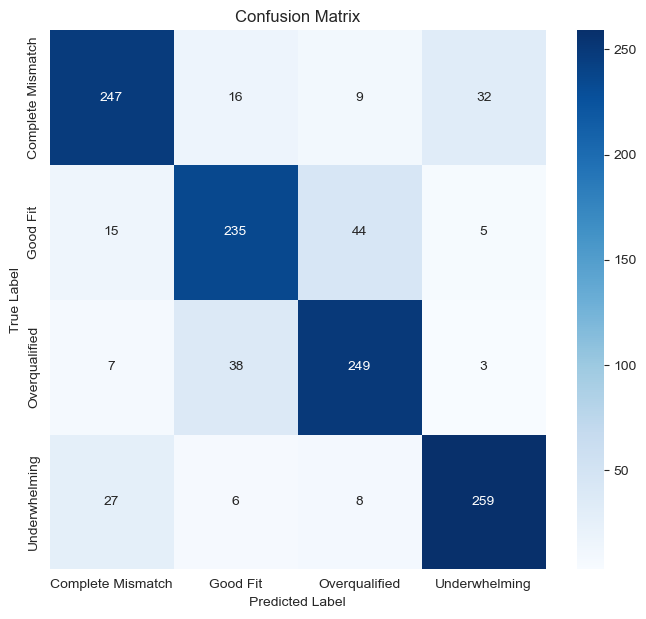

In [17]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### RandomForestClassifier

In [18]:
model = RandomForestClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train_transformed, y_train, n_splits=5)


Cross-validation scores: [0.95520833 0.9625     0.93958333 0.946875   0.940625  ]
Mean accuracy: 0.9490
Standard deviation: 0.0088


In [19]:
# Train model on full training set
model.fit(X_train_transformed, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_transformed)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.96      0.97      0.97       304
         Good Fit       0.92      0.94      0.93       299
    Overqualified       0.95      0.93      0.94       297
    Underwhelming       0.98      0.96      0.97       300

         accuracy                           0.95      1200
        macro avg       0.95      0.95      0.95      1200
     weighted avg       0.95      0.95      0.95      1200


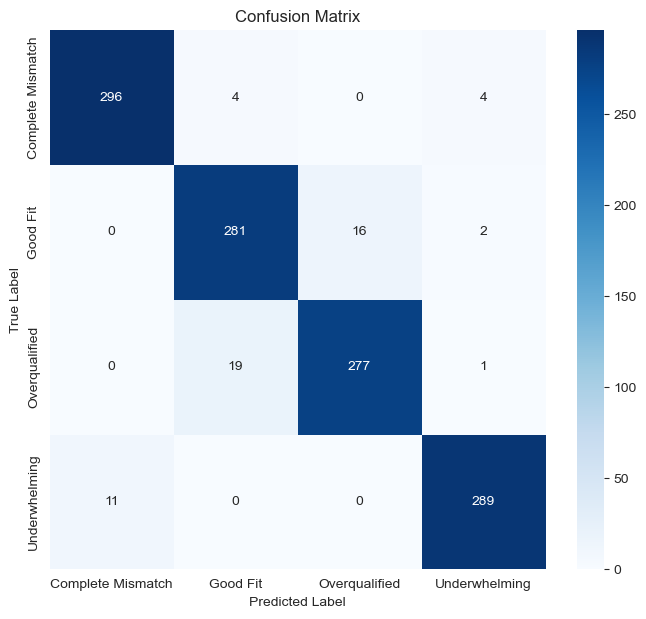

In [20]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

In [21]:
# 1-Complete Mismatch
# 2-Good fit
# 2-Overqualified
# 3-Underwhelming

model.predict_proba(X_test_transformed)

array([[0.03, 0.01, 0.  , 0.96],
       [0.16, 0.02, 0.08, 0.74],
       [0.03, 0.  , 0.  , 0.97],
       ...,
       [0.06, 0.47, 0.46, 0.01],
       [0.26, 0.05, 0.  , 0.69],
       [0.16, 0.2 , 0.61, 0.03]], shape=(1200, 4))

#### Checking for most important features

Since we are using TF-IDF, words would be our features. We are trying to see if there are any features that are directly correlated to target. This gives us information if there is any Data Leakage

In [22]:
# Get Feature Importance from XGBoost
feature_importance = model.feature_importances_

# Get Feature Names
job_features = np.array(tfidf1.get_feature_names_out())  # Job description words
resume_features = np.array(tfidf2.get_feature_names_out())  # Resume words

# Split importance back into Job Description & Resume parts
job_feature_importance = feature_importance[:len(job_features)]
resume_feature_importance = feature_importance[len(job_features):]

# Create Sorted DataFrames
job_df = pd.DataFrame({'Word': job_features, 'Importance': job_feature_importance}).sort_values(by="Importance", ascending=False)
resume_df = pd.DataFrame({'Word': resume_features, 'Importance': resume_feature_importance}).sort_values(by="Importance", ascending=False)

In [23]:
job_df.head(30)

,Word,Importance
98,engineering,0.001711
37,care,0.001619
78,design,0.001334
34,business,0.001310
302,technical,0.001282
82,development,0.001165
175,manager,0.001151
297,systems,0.001131
2,ability,0.001117
333,years,0.001040


In [24]:
resume_df.head(30)

,Word,Importance
148,seeking,0.038998
4,2010,0.026097
29,background,0.024763
157,strategic,0.024308
12,25,0.023720
3,2005,0.022018
13,30,0.021849
94,leading,0.020940
75,highly,0.018375
97,leverage,0.017574


The high performance might be due to clear decision boundaries as each of the resume with different fit categories is designed to be widely different from one category to another.